# Import Library

In [ ]:
pip install scikeras[tensorflow]


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gensim
from wordcloud import WordCloud, STOPWORDS
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from keras.models import model_from_json
import pickle
import json
import logging

logging.basicConfig(format = '%(asctime)s : %(levelname) s : %(message)s', level = logging.INFO)

print('ALL LIBRARY IMPORTED.')

from google.colab import drive
drive.mount('/content/drive')

ALL LIBRARY IMPORTED.


# Load & Preprocess Data

In [ ]:
df = pd.read_csv('drive/Sentyment Analysis using Boosting/tweets_data.csv')
print('Data loaded.\n')

Data loaded.



In [ ]:
df.drop('Unnamed: 0', axis=1, inplace = True)
df.dropna(inplace = True)

## Take random 10.000 data from each labels, total 20.000 data

In [ ]:
df_1 = df[df['label'] == 1]
df_0 = df[df['label'] == 0]

df_1 = df_1.sample(n = 10000)
df_0 = df_0.sample(n = 10000)

In [ ]:
df = pd.concat([df_1, df_0], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

# Build Corpus

In [ ]:
# Frequent words removal
freq = ['rt','im','ð','ðð','ððð','ðððð','ððððð','amp','u','â','retweet']
df['tweet_punc_remv'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.drop('tweet', axis = 1, inplace = True)
df = df.rename(columns = {'tweet_punc_remv':'tweet'})

# Membuat korpus
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)

# Memberi indeks pada teks
token = Tokenizer()
token.fit_on_texts(corpus)
token.index_word
token.texts_to_sequences(corpus)

#Jumlah kata dalam korpus
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 24441 words.


# Defining X and Y & Pad sequences

In [ ]:
maxword = 30
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxword, padding = 'post')
y = df['label'].values.tolist()
print('X and y defined')

X and y defined


# Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42)
print('Training and testing data defined.')

Training and testing data defined.


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('Done')

Done


# FastText

## Embedding layer

In [ ]:
pretrainedpath = 'drive/Sentyment Analysis using Boosting/fasttext_model.bin'
fasttext_model = KeyedVectors.load_word2vec_format('drive/Sentyment Analysis using Boosting/fasttext_model.bin', binary = True, limit = 150000)
print('Model fasttext loaded.')

In [ ]:
embedding_layer = Embedding(input_dim = 150000, output_dim = 300, weights = [fasttext_model.vectors], 
                            input_length = X.shape[1], trainable = False)
print('Embedding layer defined.')

Embedding layer defined.


## Hyperparameter Tuning Parameter Model Fast Text

In [ ]:
def get_model_cnn_3(learning_rate = 0.01):

  #Define model
    model = Sequential()
    model.add(embedding_layer)
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
 
    #Compile model
    adam = Adam(learning_rate = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [ ]:
%%time
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10)

# Memdefinisikan Model
model_cnn_3 = KerasClassifier(model = get_model_cnn_3,
                             callbacks = [monitor],epochs = 100,
                             learning_rate = 0.01, verbose = 1)

# define the grid search parameters
params_cnn_3 = {'batch_size': [32,64,128],
              'learning_rate': [0.01,0.001],
              'epochs': [50,100]}

ht_cnn_3 = GridSearchCV(model_cnn_3,
                       param_grid = params_cnn_3,
                       scoring = 'accuracy')

hyt_cnn_3 = ht_cnn_3.fit(X_train, y_train, validation_data = (X_test, y_test));
print("\nThe best parameter is {}".format(hyt_cnn_3.best_params_))
print("\nThe best_accuracy is {}".format(hyt_cnn_3.best_score_))

Epoch 1/50
375/375 [==============================] - 9s 22ms/step - loss: 0.5708 - accuracy: 0.7113 - val_loss: 0.5391 - val_accuracy: 0.6632
Epoch 2/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3724 - accuracy: 0.8393 - val_loss: 0.3264 - val_accuracy: 0.8518
Epoch 3/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3306 - accuracy: 0.8595 - val_loss: 0.3013 - val_accuracy: 0.8728
Epoch 4/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3034 - accuracy: 0.8766 - val_loss: 0.2845 - val_accuracy: 0.8830
Epoch 5/50
375/375 [==============================] - 8s 20ms/step - loss: 0.2776 - accuracy: 0.8861 - val_loss: 0.2980 - val_accuracy: 0.8828
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - loss: 0.2651 - accuracy: 0.8929 - val_loss: 0.3398 - val_accuracy: 0.8748
Epoch 7/50
375/375 [==============================] - 8s 20ms/step - loss: 0.2397 - accuracy: 0.9013 - val_loss: 0.2736 - val_accuracy: 0.8840

375/375 [==============================] - 9s 22ms/step - loss: 0.5993 - accuracy: 0.6823 - val_loss: 0.5962 - val_accuracy: 0.5464
Epoch 2/50
375/375 [==============================] - 8s 22ms/step - loss: 0.3969 - accuracy: 0.8294 - val_loss: 0.3375 - val_accuracy: 0.8588
Epoch 3/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3330 - accuracy: 0.8608 - val_loss: 0.3010 - val_accuracy: 0.8668
Epoch 4/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3055 - accuracy: 0.8723 - val_loss: 0.2863 - val_accuracy: 0.8818
Epoch 5/50
375/375 [==============================] - 8s 21ms/step - loss: 0.2809 - accuracy: 0.8810 - val_loss: 0.2923 - val_accuracy: 0.8718
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - loss: 0.2633 - accuracy: 0.8921 - val_loss: 0.2731 - val_accuracy: 0.8900
Epoch 7/50
375/375 [==============================] - 8s 21ms/step - loss: 0.2465 - accuracy: 0.8983 - val_loss: 0.2784 - val_accuracy: 0.8862
Epoch 8/50

375/375 [==============================] - 9s 21ms/step - loss: 0.5821 - accuracy: 0.6967 - val_loss: 0.8271 - val_accuracy: 0.5080
Epoch 2/100
375/375 [==============================] - 8s 21ms/step - loss: 0.3804 - accuracy: 0.8342 - val_loss: 0.5296 - val_accuracy: 0.6926
Epoch 3/100
375/375 [==============================] - 8s 21ms/step - loss: 0.3331 - accuracy: 0.8574 - val_loss: 0.3152 - val_accuracy: 0.8716
Epoch 4/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2953 - accuracy: 0.8776 - val_loss: 0.2783 - val_accuracy: 0.8854
Epoch 5/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2827 - accuracy: 0.8823 - val_loss: 0.2815 - val_accuracy: 0.8864
Epoch 6/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2599 - accuracy: 0.8936 - val_loss: 0.2932 - val_accuracy: 0.8824
Epoch 7/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2423 - accuracy: 0.9013 - val_loss: 0.2972 - val_accuracy: 0.8868
Epoc

375/375 [==============================] - 9s 22ms/step - loss: 0.5992 - accuracy: 0.6878 - val_loss: 0.6099 - val_accuracy: 0.6140
Epoch 2/100
375/375 [==============================] - 8s 22ms/step - loss: 0.3823 - accuracy: 0.8378 - val_loss: 0.3254 - val_accuracy: 0.8656
Epoch 3/100
375/375 [==============================] - 8s 22ms/step - loss: 0.3325 - accuracy: 0.8591 - val_loss: 0.3381 - val_accuracy: 0.8660
Epoch 4/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2994 - accuracy: 0.8733 - val_loss: 0.5181 - val_accuracy: 0.7122
Epoch 5/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2784 - accuracy: 0.8845 - val_loss: 0.2831 - val_accuracy: 0.8840
Epoch 6/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2603 - accuracy: 0.8915 - val_loss: 0.2761 - val_accuracy: 0.8882
Epoch 7/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2391 - accuracy: 0.9013 - val_loss: 0.2882 - val_accuracy: 0.8814
Epoc

188/188 [==============================] - 9s 41ms/step - loss: 0.6384 - accuracy: 0.6697 - val_loss: 0.6548 - val_accuracy: 0.5518
Epoch 2/50
188/188 [==============================] - 7s 39ms/step - loss: 0.3985 - accuracy: 0.8222 - val_loss: 0.5198 - val_accuracy: 0.8460
Epoch 3/50
188/188 [==============================] - 7s 40ms/step - loss: 0.3291 - accuracy: 0.8593 - val_loss: 0.3790 - val_accuracy: 0.8646
Epoch 4/50
188/188 [==============================] - 8s 40ms/step - loss: 0.2966 - accuracy: 0.8788 - val_loss: 0.2774 - val_accuracy: 0.8830
Epoch 5/50
188/188 [==============================] - 7s 39ms/step - loss: 0.2721 - accuracy: 0.8865 - val_loss: 0.3023 - val_accuracy: 0.8678
Epoch 6/50
188/188 [==============================] - 7s 39ms/step - loss: 0.2592 - accuracy: 0.8928 - val_loss: 0.2790 - val_accuracy: 0.8860
Epoch 7/50
188/188 [==============================] - 8s 41ms/step - loss: 0.2312 - accuracy: 0.9041 - val_loss: 0.2802 - val_accuracy: 0.8830
Epoch 8/50

188/188 [==============================] - 9s 41ms/step - loss: 0.6120 - accuracy: 0.6891 - val_loss: 0.6654 - val_accuracy: 0.5892
Epoch 2/50
188/188 [==============================] - 8s 41ms/step - loss: 0.3860 - accuracy: 0.8285 - val_loss: 0.5629 - val_accuracy: 0.6994
Epoch 3/50
188/188 [==============================] - 8s 42ms/step - loss: 0.3355 - accuracy: 0.8567 - val_loss: 0.3729 - val_accuracy: 0.8492
Epoch 4/50
188/188 [==============================] - 8s 41ms/step - loss: 0.3040 - accuracy: 0.8722 - val_loss: 0.3199 - val_accuracy: 0.8532
Epoch 5/50
188/188 [==============================] - 8s 42ms/step - loss: 0.2727 - accuracy: 0.8861 - val_loss: 0.2869 - val_accuracy: 0.8792
Epoch 6/50
188/188 [==============================] - 8s 41ms/step - loss: 0.2505 - accuracy: 0.8979 - val_loss: 0.3315 - val_accuracy: 0.8732
Epoch 7/50
188/188 [==============================] - 8s 40ms/step - loss: 0.2389 - accuracy: 0.9031 - val_loss: 0.3355 - val_accuracy: 0.8796
Epoch 8/50

188/188 [==============================] - 9s 40ms/step - loss: 0.6164 - accuracy: 0.6792 - val_loss: 0.7990 - val_accuracy: 0.5048
Epoch 2/100
188/188 [==============================] - 7s 39ms/step - loss: 0.3910 - accuracy: 0.8288 - val_loss: 0.5253 - val_accuracy: 0.8334
Epoch 3/100
188/188 [==============================] - 7s 38ms/step - loss: 0.3256 - accuracy: 0.8645 - val_loss: 0.3532 - val_accuracy: 0.8716
Epoch 4/100
188/188 [==============================] - 8s 42ms/step - loss: 0.2944 - accuracy: 0.8781 - val_loss: 0.3349 - val_accuracy: 0.8614
Epoch 5/100
188/188 [==============================] - 8s 41ms/step - loss: 0.2699 - accuracy: 0.8861 - val_loss: 0.3346 - val_accuracy: 0.8456
Epoch 6/100
188/188 [==============================] - 7s 39ms/step - loss: 0.2455 - accuracy: 0.9000 - val_loss: 0.5687 - val_accuracy: 0.8344
Epoch 7/100
188/188 [==============================] - 8s 42ms/step - loss: 0.2288 - accuracy: 0.9040 - val_loss: 0.3096 - val_accuracy: 0.8566
Epoc

188/188 [==============================] - 8s 41ms/step - loss: 0.3796 - accuracy: 0.8371 - val_loss: 0.5545 - val_accuracy: 0.7000
Epoch 3/100
188/188 [==============================] - 7s 40ms/step - loss: 0.3297 - accuracy: 0.8627 - val_loss: 0.3882 - val_accuracy: 0.8458
Epoch 4/100
188/188 [==============================] - 8s 40ms/step - loss: 0.2973 - accuracy: 0.8751 - val_loss: 0.3975 - val_accuracy: 0.8422
Epoch 5/100
188/188 [==============================] - 8s 41ms/step - loss: 0.2688 - accuracy: 0.8886 - val_loss: 0.2706 - val_accuracy: 0.8882
Epoch 6/100
188/188 [==============================] - 8s 40ms/step - loss: 0.2576 - accuracy: 0.8962 - val_loss: 0.2768 - val_accuracy: 0.8866
Epoch 7/100
188/188 [==============================] - 7s 40ms/step - loss: 0.2271 - accuracy: 0.9087 - val_loss: 0.2896 - val_accuracy: 0.8858
Epoch 8/100
188/188 [==============================] - 8s 40ms/step - loss: 0.2110 - accuracy: 0.9142 - val_loss: 0.2949 - val_accuracy: 0.8880
Epoc

188/188 [==============================] - 8s 40ms/step - loss: 0.4054 - accuracy: 0.8220 - val_loss: 0.5999 - val_accuracy: 0.6362
Epoch 3/100
188/188 [==============================] - 8s 40ms/step - loss: 0.3350 - accuracy: 0.8558 - val_loss: 0.3748 - val_accuracy: 0.8544
Epoch 4/100
188/188 [==============================] - 7s 39ms/step - loss: 0.2949 - accuracy: 0.8758 - val_loss: 0.3376 - val_accuracy: 0.8578
Epoch 5/100
188/188 [==============================] - 7s 39ms/step - loss: 0.2770 - accuracy: 0.8840 - val_loss: 0.3223 - val_accuracy: 0.8706
Epoch 6/100
188/188 [==============================] - 7s 39ms/step - loss: 0.2579 - accuracy: 0.8938 - val_loss: 0.3278 - val_accuracy: 0.8440
Epoch 7/100
188/188 [==============================] - 7s 39ms/step - loss: 0.2379 - accuracy: 0.9047 - val_loss: 0.2956 - val_accuracy: 0.8812
Epoch 8/100
188/188 [==============================] - 7s 39ms/step - loss: 0.2205 - accuracy: 0.9097 - val_loss: 0.2856 - val_accuracy: 0.8836
Epoc

Epoch 2/50
94/94 [==============================] - 6s 68ms/step - loss: 0.4244 - accuracy: 0.8079 - val_loss: 0.5956 - val_accuracy: 0.8214
Epoch 3/50
94/94 [==============================] - 7s 69ms/step - loss: 0.3516 - accuracy: 0.8501 - val_loss: 0.6088 - val_accuracy: 0.5404
Epoch 4/50
94/94 [==============================] - 6s 68ms/step - loss: 0.3052 - accuracy: 0.8721 - val_loss: 0.4670 - val_accuracy: 0.8220
Epoch 5/50
94/94 [==============================] - 6s 68ms/step - loss: 0.2812 - accuracy: 0.8802 - val_loss: 0.3745 - val_accuracy: 0.8494
Epoch 6/50
94/94 [==============================] - 7s 70ms/step - loss: 0.2507 - accuracy: 0.8969 - val_loss: 0.3125 - val_accuracy: 0.8716
Epoch 7/50
94/94 [==============================] - 6s 68ms/step - loss: 0.2354 - accuracy: 0.9042 - val_loss: 0.3233 - val_accuracy: 0.8480
Epoch 8/50
94/94 [==============================] - 6s 67ms/step - loss: 0.2081 - accuracy: 0.9159 - val_loss: 0.2831 - val_accuracy: 0.8836
Epoch 9/50
94

94/94 [==============================] - 8s 69ms/step - loss: 0.6369 - accuracy: 0.6711 - val_loss: 0.7341 - val_accuracy: 0.5048
Epoch 2/50
94/94 [==============================] - 6s 67ms/step - loss: 0.4143 - accuracy: 0.8182 - val_loss: 0.5903 - val_accuracy: 0.8500
Epoch 3/50
94/94 [==============================] - 6s 67ms/step - loss: 0.3413 - accuracy: 0.8543 - val_loss: 0.6126 - val_accuracy: 0.5226
Epoch 4/50
94/94 [==============================] - 6s 67ms/step - loss: 0.3051 - accuracy: 0.8707 - val_loss: 0.6175 - val_accuracy: 0.5394
Epoch 5/50
94/94 [==============================] - 6s 67ms/step - loss: 0.2779 - accuracy: 0.8836 - val_loss: 0.4545 - val_accuracy: 0.7246
Epoch 6/50
94/94 [==============================] - 6s 68ms/step - loss: 0.2551 - accuracy: 0.8974 - val_loss: 0.4067 - val_accuracy: 0.8026
Epoch 7/50
94/94 [==============================] - 6s 67ms/step - loss: 0.2351 - accuracy: 0.9055 - val_loss: 0.3110 - val_accuracy: 0.8570
Epoch 8/50
94/94 [======

Epoch 2/100
94/94 [==============================] - 6s 69ms/step - loss: 0.4243 - accuracy: 0.8096 - val_loss: 0.6964 - val_accuracy: 0.5050
Epoch 3/100
94/94 [==============================] - 7s 72ms/step - loss: 0.3358 - accuracy: 0.8582 - val_loss: 0.8291 - val_accuracy: 0.5050
Epoch 4/100
94/94 [==============================] - 7s 74ms/step - loss: 0.3044 - accuracy: 0.8723 - val_loss: 0.6909 - val_accuracy: 0.5398
Epoch 5/100
94/94 [==============================] - 7s 72ms/step - loss: 0.2803 - accuracy: 0.8814 - val_loss: 0.7650 - val_accuracy: 0.5646
Epoch 6/100
94/94 [==============================] - 7s 70ms/step - loss: 0.2518 - accuracy: 0.8957 - val_loss: 0.3963 - val_accuracy: 0.7752
Epoch 7/100
94/94 [==============================] - 6s 68ms/step - loss: 0.2329 - accuracy: 0.9028 - val_loss: 0.2978 - val_accuracy: 0.8722
Epoch 8/100
94/94 [==============================] - 6s 69ms/step - loss: 0.2078 - accuracy: 0.9172 - val_loss: 0.2947 - val_accuracy: 0.8648
Epoch 

94/94 [==============================] - 7s 71ms/step - loss: 0.1790 - accuracy: 0.9305 - val_loss: 0.2904 - val_accuracy: 0.8804
Epoch 10/100
94/94 [==============================] - 7s 70ms/step - loss: 0.1672 - accuracy: 0.9355 - val_loss: 0.5628 - val_accuracy: 0.8494
Epoch 11/100
94/94 [==============================] - 7s 70ms/step - loss: 0.1602 - accuracy: 0.9377 - val_loss: 0.3074 - val_accuracy: 0.8704
Epoch 12/100
24/24 [==============================] - 0s 14ms/step
Epoch 1/100
94/94 [==============================] - 9s 74ms/step - loss: 0.6687 - accuracy: 0.6492 - val_loss: 0.7217 - val_accuracy: 0.5048
Epoch 2/100
94/94 [==============================] - 7s 73ms/step - loss: 0.4317 - accuracy: 0.8089 - val_loss: 0.6961 - val_accuracy: 0.5048
Epoch 3/100
94/94 [==============================] - 7s 74ms/step - loss: 0.3522 - accuracy: 0.8497 - val_loss: 0.6672 - val_accuracy: 0.5362
Epoch 4/100
94/94 [==============================] - 7s 75ms/step - loss: 0.3100 - accuracy

### Fit Model Fast Text

In [ ]:
%%time
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10 )

model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu'))
model_3.add(MaxPooling1D(pool_size = 3))
model_3.add(BatchNormalization())
model_3.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
model_3.add(MaxPooling1D(pool_size = 3))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Flatten())
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(128, activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(64,activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))
model_3.add(Dense(1, activation = 'sigmoid'))
 
#Compile model
adam = Adam(learning_rate = 0.01)
model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_3.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization_372 (Ba  (None, 30, 300)          1200      
 tchNormalization)                                               
                                                                 
 dropout_310 (Dropout)       (None, 30, 300)           0         
                                                                 
 conv1d_124 (Conv1D)         (None, 30, 256)           384256    
                                                                 
 max_pooling1d_124 (MaxPooli  (None, 10, 256)          0         
 ng1D)                                                           
                                                                 
 batch_normalization_373 (Ba  (None, 10, 256)        

In [ ]:
model_fasttext = model_3.fit(X_train, y_train, 
                          epochs = 50, callbacks = [monitor],
                          batch_size = 32,
                          validation_data = (X_test, y_test))

Epoch 1/50
469/469 [==============================] - 13s 24ms/step - loss: 0.5603 - accuracy: 0.7199 - val_loss: 0.5280 - val_accuracy: 0.6412
Epoch 2/50
469/469 [==============================] - 11s 24ms/step - loss: 0.3655 - accuracy: 0.8420 - val_loss: 0.3143 - val_accuracy: 0.8658
Epoch 3/50
469/469 [==============================] - 11s 24ms/step - loss: 0.3194 - accuracy: 0.8653 - val_loss: 0.2837 - val_accuracy: 0.8814
Epoch 4/50
469/469 [==============================] - 11s 24ms/step - loss: 0.2955 - accuracy: 0.8771 - val_loss: 0.2808 - val_accuracy: 0.8820
Epoch 5/50
469/469 [==============================] - 11s 24ms/step - loss: 0.2761 - accuracy: 0.8868 - val_loss: 0.3041 - val_accuracy: 0.8734
Epoch 6/50
469/469 [==============================] - 11s 24ms/step - loss: 0.2562 - accuracy: 0.8934 - val_loss: 0.2631 - val_accuracy: 0.8928
Epoch 7/50
469/469 [==============================] - 11s 24ms/step - loss: 0.2412 - accuracy: 0.9009 - val_loss: 0.2931 - val_accuracy:

## Evaluate Model Fast Text

In [ ]:
loss_fasttext, acc_fasttext = model_3.evaluate(X_test, y_test, batch_size = 32)
print('Model loss: {}'.format(loss_fasttext))
print('Model acc: {}'.format(acc_fasttext))

157/157 [==============================] - 1s 6ms/step - loss: 0.2938 - accuracy: 0.8960
Model loss: 0.29384860396385193
Model acc: 0.8960000276565552


## Visualization Model Fast Text

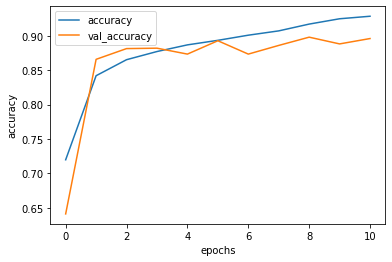

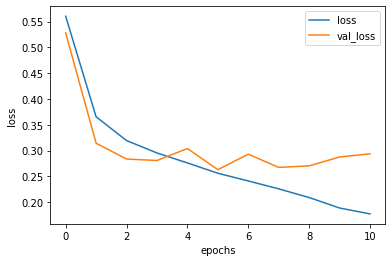

In [ ]:
def plot_graphs(model_fasttext,string):
    plt.plot(model_fasttext.history[string])
    plt.plot(model_fasttext.history['val_'+string])
    plt.xlabel("epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(model_fasttext, "accuracy")
plot_graphs(model_fasttext, "loss") 

In [ ]:
y_pred = model_3.predict(X_test)
print('Prediction done.')

157/157 [==============================] - 1s 6ms/step
Prediction done.


In [ ]:
y_pred

array([[0.14657657],
       [0.9900751 ],
       [0.9995856 ],
       ...,
       [0.9994422 ],
       [0.06581802],
       [0.01872385]], dtype=float32)

In [ ]:
labels = [0,1]

In [ ]:
prediction_labels=[]
for p in y_pred:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(y_test==prediction_labels)/len(prediction_labels)

0.4952

In [ ]:
y_pred = prediction_labels

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2476    0]
 [2524    0]]


In [ ]:
print(classification_report(y_test, y_pred,zero_division = 1))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2476
           1       0.00      0.00      0.00      2524

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


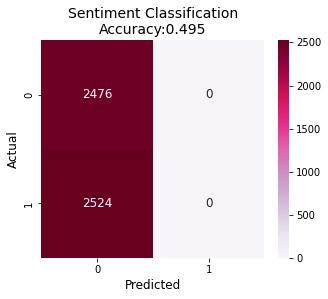

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.66      2476
           1       0.00      0.00      0.00      2524

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_test, y_pred)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 1))

# Boosting

In [ ]:
from xgboost import XGBClassifier

xgboost_3 = XGBClassifier(n_estimators = 1000, learning_rate = 0.01).fit(X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_test, y_test)],verbose = False)
score_xgb_3 = xgboost_3.score(X_test,y_test)
score_xgb_3

0.9018

In [ ]:
#Predict the response for test dataset
y_boost_pred_3 = xgboost_3.predict(X_test)

In [ ]:
# Print classification report
print(classification_report(y_test, y_boost_pred_3))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2476
           1       0.92      0.88      0.90      2524

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [ ]:
cmb_3 = confusion_matrix(y_test,y_boost_pred_3)
cmb_3

array([[2285,  191],
       [ 300, 2224]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix FastText for Sentiment Classification after Boosting')

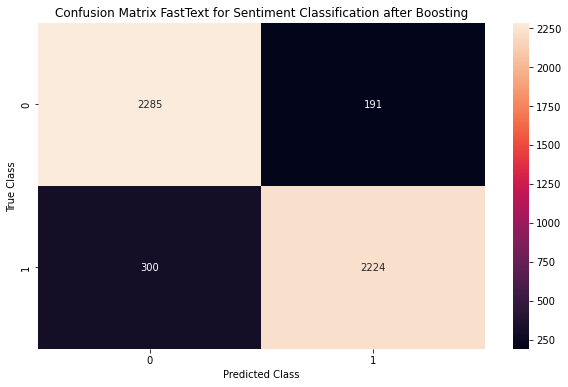

In [ ]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cmb_3, annot = True,fmt = "d")

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix FastText for Sentiment Classification after Boosting")